In [1]:
# default_exp preprocess.interpolate_target

# Preprocess Target

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [15]:
#export
import os
import pickle

import numpy as np
import meshio
from scipy.spatial import Delaunay

## interpolate solutions from nodes to grid

In [4]:
#export
class VTUContent:
    def __init__(self, coords, connectivity_quad, field):
        coords = coords[:, :2]
        connectivity = self._quad_to_tri(connectivity_quad)

        self.mesh = self._make_delaunay_mesh(coords, connectivity)
        self.field = field

    def _quad_to_tri(self, connectivity_quad):
        connectivity = []
        for element_nodes in connectivity_quad:
            triangle1_nodes = element_nodes[[0, 1, 2]]
            triangle2_nodes = element_nodes[[0, 2, 3]]

            connectivity.append(triangle1_nodes)
            connectivity.append(triangle2_nodes)

        return np.array(connectivity)

    def _make_delaunay_mesh(self, coords, connectivity):
        mesh = Delaunay(coords)
        mesh.simplices = connectivity.astype(np.int32)
        return mesh

In [5]:
#export
def read_vtu_file(path, field_name):
    mesh_meshio = meshio.read(path)
    #TODO: fix this hack
    if field_name == 'solution': field_name = 'displacement'
    data = VTUContent(
        mesh_meshio.points,
        mesh_meshio.cells[0].data,
        mesh_meshio.point_data[field_name])

    return data

In [16]:
path_project = os.path.join(os.getcwd(), '..', "..")
path_vtu = os.path.join(path_project, 'examples', 'box_w_aggr', 'data', 'raw', '0', 'plastic_strain', 'plastic_strain_50.vtu')
field_name = 'plastic_strain'


data_nodal = read_vtu_file(path_vtu, field_name)

data_nodal.mesh.simplices.shape, data_nodal.field.shape

((7790, 3), (15580,))

In [17]:
path_abs_geo = os.path.join(path_project, "examples", 'box_w_aggr', 'data', 'raw', '0', 'abstract_geometry.pickle')

#hide
with open(path_abs_geo, 'rb') as file:
    abstract_geometry = pickle.load(file)

In [22]:
#export
def make_grid(resolution, abstract_geometry):
    _, box_coord_dim = abstract_geometry.get_geom_info()
    x, y, dx, dy = box_coord_dim

    x = np.linspace(x, x+dx, resolution[0], dtype=np.float32)
    y = np.linspace(y, y+dy, resolution[1], dtype=np.float32)

    grid_x, grid_y = np.meshgrid(x, y)
    grid_flat = np.hstack([grid_x.flatten()[:, None], grid_y.flatten()[:, None]])

    return grid_x, grid_y, grid_flat

In [23]:
resolution = (128, 128)

grid_x, grid_y, grid_flat = make_grid(resolution, abstract_geometry)
grid_flat.shape

(16384, 2)

In [24]:
#export
def compute_tri3_shape_function_at(coord, el_coords):
    x1 = el_coords[0][0]; y1 = el_coords[0][1]
    x2 = el_coords[1][0]; y2 = el_coords[1][1]
    x3 = el_coords[2][0]; y3 = el_coords[2][1]

    a0 = x1; b0 = y1
    a1 = x2 - x1; b1 = y2 - y1
    a2 = x3 - x1; b2 = y3 - y1

    xhat = coord[0]; yhat = coord[1]

    etahat = (a1 * yhat - b1 * xhat + b1 * a0 - a1 * b0) / (a1 * b2 - a2 * b1 + 1e-8)
    xihat = (xhat - a0 - a2 * etahat) / (a1 + 1e-8)

    n1 = 1 - xihat - etahat
    n2 = xihat
    n3 = etahat
    return np.array([n1, n2, n3])

In [28]:
#export
def find_grids_in_each_element(mesh, grid_flat):
    grid_point_to_element = mesh.find_simplex(grid_flat, bruteforce=True, tol=1e-1)
    element_to_grid_points = [None for e in range(len(mesh.simplices))]

    for eid in range(len(element_to_grid_points)):
        element_to_grid_points[eid] = np.where(grid_point_to_element == eid)[0]

    return element_to_grid_points

In [29]:
#export
def interpolate(data_nodal, resolution, abstract_geometry, verbose=False):
    grid_x, grid_y, grid_flat = make_grid(resolution, abstract_geometry)
    grid_dim = grid_y.shape

    if verbose: print('[INFO]: finding grids in each element ..')
    element_to_grid_points = find_grids_in_each_element(data_nodal.mesh, grid_flat)

    if len(data_nodal.field.shape)>1: field_dim = data_nodal.field.shape[1]
    else: field_dim = 1

    field_grid = np.zeros([grid_flat.shape[0], field_dim])

    if verbose: print('[INFO]: interpolating ..')
    for element, grid_points_in_element in enumerate(element_to_grid_points):
        element_nodes = data_nodal.mesh.simplices[element]
        element_coords = data_nodal.mesh.points[element_nodes]
        field_at_element_nodes = data_nodal.field[element_nodes]

        for grid_point in grid_points_in_element:
            grid_coord = grid_flat[grid_point]
            n = compute_tri3_shape_function_at(grid_coord, element_coords)
            f = n.dot(field_at_element_nodes)
            
            field_grid[grid_point] = f
    
    field_grid = field_grid.reshape(*grid_dim, field_dim)

    return field_grid

In [31]:
fields_grid = interpolate(data_nodal, resolution, abstract_geometry, verbose=True)
fields_grid.shape

[INFO]: finding grids in each element ..
[INFO]: interpolating ..


(128, 128, 1)

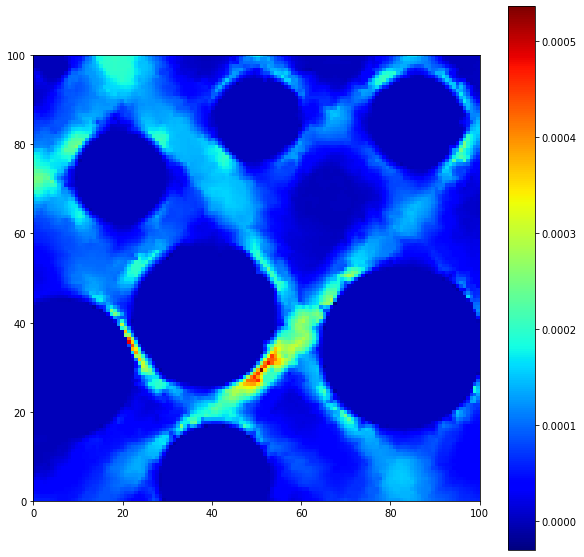

In [33]:
field_grid = fields_grid
levels = np.linspace(fields_grid.min(), fields_grid.max())

plt.figure(figsize=(10, 10))
plt.imshow(field_grid, extent=[0, 100, 0, 100], cmap='jet')
plt.colorbar()